Crop vs Weed Classification Model Training and Evaluation

This notebook demonstrates the complete process for loading image data, preprocessing, building a Convolutional Neural Network (CNN), training, and evaluating the model using multiple metrics, which serves as the core ML component for the MLOps deployment.

1. Setup and Data Loading

We load the necessary libraries and create the training and validation datasets directly from the structured image directory.

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [9]:
# --- Configuration ---
BATCH_SIZE = 32
IMG_SIZE = (150, 150)
DATA_DIR = r"C:\Users\LENOVO\Downloads\CropWeedProject\dataset\train" 

# Load datasets, splitting 80/20 for training/validation
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
print(f"Classes found: {class_names}")

Found 2465 files belonging to 2 classes.
Using 1972 files for training.
Found 2465 files belonging to 2 classes.
Using 493 files for validation.
Classes found: ['crop', 'weed']


In [10]:
# Configure dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

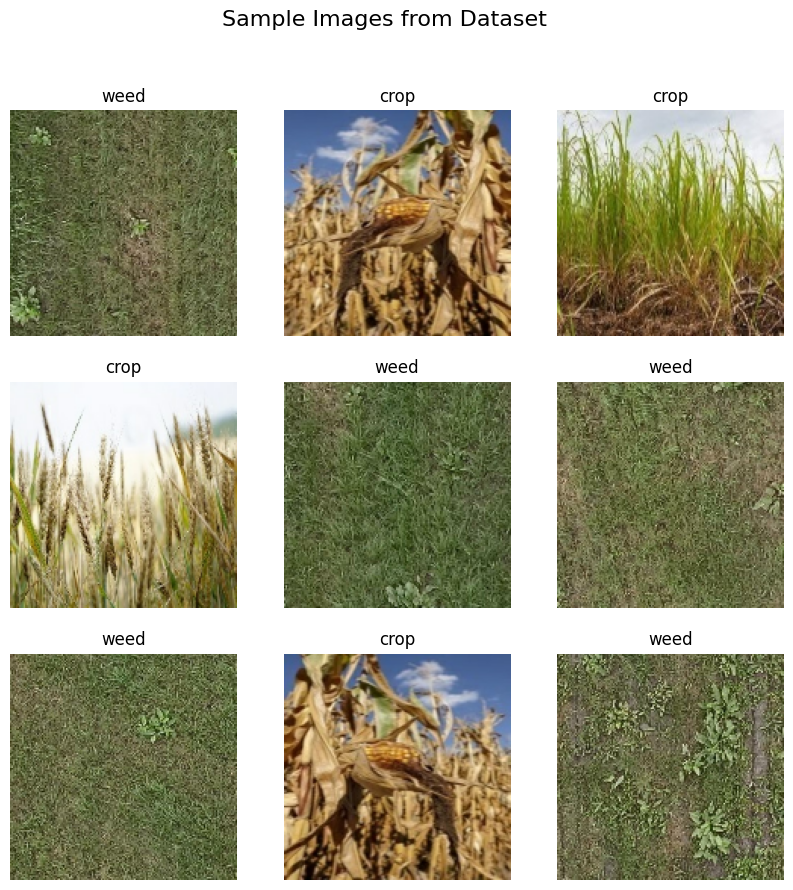

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # Convert tensor to numpy and cast to int for display
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.suptitle("Sample Images from Dataset", fontsize=16)
plt.show()

2. Preprocessing and Model Definition

Preprocessing (Normalization)

We apply a Rescaling layer to normalize pixel values from $[0, 255]$ to $[0, 1]$.

In [12]:
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

Model Architecture (Standard CNN)

The model uses a sequential CNN structure for feature extraction, followed by dense layers for classification.

In [13]:
model = models.Sequential([
    layers.Input(shape=(150, 150, 3)),

    # Optimization Step 1: Feature Extraction

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),

    # Optimization Step 2: Dropout for Regularization (to prevent overfitting)
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid') # Binary classification (Crop vs Weed)
])
# Using Adam optimizer (Optimization Step 3)
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

3. Training and Visualization

We train the model for 25 epochs.

In [14]:
# Optimization Step 4: Early Stopping (to halt training if validation loss plateaus)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=[early_stopping]
)

Epoch 1/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 408ms/step - accuracy: 0.8808 - loss: 0.2708 - val_accuracy: 0.9980 - val_loss: 0.0074
Epoch 2/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 23s 374ms/step - accuracy: 0.9280 - loss: 0.2665 - val_accuracy: 0.9939 - val_loss: 0.0139
Epoch 3/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 23s 370ms/step - accuracy: 0.9797 - loss: 0.0640 - val_accuracy: 0.9757 - val_loss: 0.0624
Epoch 4/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 24s 379ms/step - accuracy: 0.9914 - loss: 0.0271 - val_accuracy: 1.0000 - val_loss: 0.0053
Epoch 5/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 23s 377ms/step - accuracy: 0.9980 - loss: 0.0082 - val_accuracy: 1.0000 - val_loss: 9.4258e-04
Epoch 6/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 23s 370ms/step - accuracy: 0.9868 - loss: 0.0464 - val_accuracy: 0.9980 - val_loss: 0.0306
Epoch 7/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9965 - loss: 0.0155 - val_accuracy: 1.0000 - val_loss: 0.0018
Epoch 8/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 24s 389ms/step - accuracy: 0.9985 - loss: 0.0063 - val_

4. Final Evaluation and Metrics

We run predictions on the validation set to calculate detailed metrics beyond just accuracy and loss, including Precision, Recall, and F1-Score.


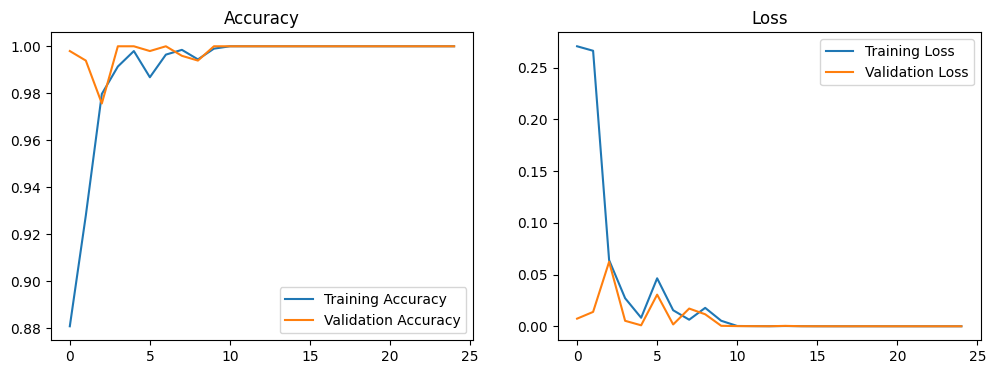

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
              precision    recall  f1-score   support

        Crop       1.00      1.00      1.00       163
        Weed       1.00      1.00      1.00       330

    accuracy                           1.00       493
   macro avg       1.00      1.00      1.00       493
weighted avg       1.00      1.00      1.00       493



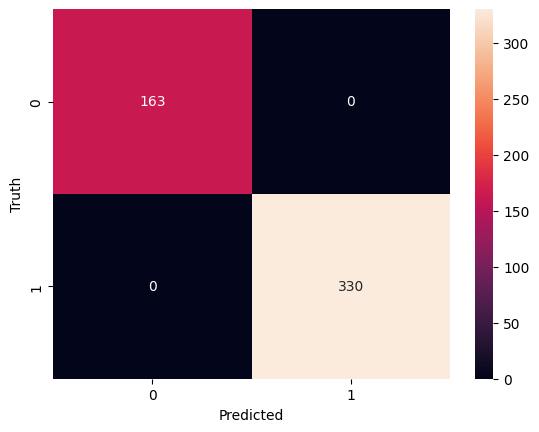

In [16]:
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend([1 if p > 0.5 else 0 for p in preds])

# Metrics
print(classification_report(y_true, y_pred, target_names=['Crop', 'Weed']))

# Confusion Matrix Visualization
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [17]:
model.save('../models/crop_weed_model.h5')
print("Model saved to models/crop_weed_model.h5")

Model saved to models/crop_weed_model.h5



--- Running Single Image Prediction Test ---
Testing against a Weed image...


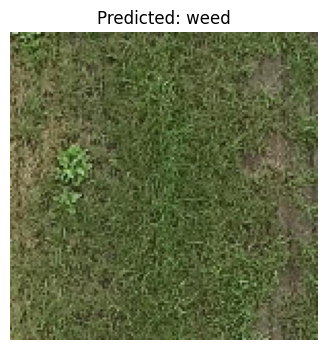

Testing against a Crop image...


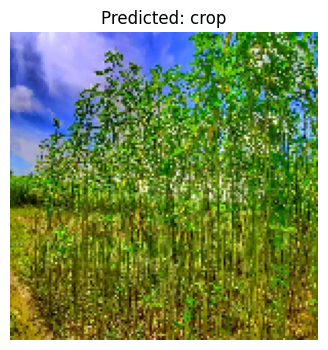

In [18]:
# Final Evaluation and Test

def predict_local_image(model, img_path, class_names):
    """
    Loads a single image, preprocesses it, and makes a prediction.
    """
    if not os.path.exists(img_path):
        print(f"Error: Test image not found at {img_path}")
        return

    # 1. Load and Preprocess Image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(150, 150))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalization matching training

    # 2. Predict
    prediction = model.predict(img_array, verbose=0)
    score = float(prediction[0][0])
    
    # 3. Interpret Result (assuming 0=Crop, 1=Weed)
    if score > 0.5:
        label_index = 1
        confidence = score
    else:
        label_index = 0
        confidence = 1.0 - score
        
    predicted_label = class_names[label_index]

    # 4. Display Result
    plt.figure(figsize=(4, 4))
    plt.imshow(img.convert("RGB"))
    plt.title(f"Predicted: {predicted_label}")
    plt.xlabel(f"Confidence: {confidence * 100:.2f}%")
    plt.axis("off")
    plt.show()


# --- EXECUTE A TEST ---
print("\n--- Running Single Image Prediction Test ---")

# You MUST find a sample image path from your test or train folder 
# and paste it here for the notebook to run the demonstration.
TEST_IMAGE_PATH_WEED = r'C:\Users\LENOVO\Downloads\CropWeedProject\dataset\test\weed\ridderzuring_4516_jpg.rf.456b309daa219ed4121309cce3314125.jpg' 
TEST_IMAGE_PATH_CROP = r'C:\Users\LENOVO\Downloads\CropWeedProject\dataset\test\crop\jute-field.jpg' 

# Note: You must ensure these files exist in your data/test folders!

# Test 1: Predict a Weed
print("Testing against a Weed image...")
predict_local_image(model, TEST_IMAGE_PATH_WEED, class_names)

# Test 2: Predict a Crop
print("Testing against a Crop image...")
predict_local_image(model, TEST_IMAGE_PATH_CROP, class_names)